# Using the SIAF class

The Science Instrument Aperture File, or **SIAF**, provides approximate conversions of sky positions to detector positions in support of operations. (More sophisticated corrections, e.g. for correcting and analyzing science data, are included in the JWST instrument pipelines.)

The SIAF class in `jwxml` allows conversions between the coordinate frames defined for science "apertures" (which could map to detectors, detector subarrays, or special modes). The choice of coordinate frames is discussed in STScI technical report JWST-STScI-001256 (Sec. 3) and summarized in technical report JWST-STScI-001550 "Description and Use of the JWST Science Instrument Aperture File", Cox et al. (2008) as follows:

>  * **Detector (Det):** The detector frame is defined by hardware considerations and usually represents raw detector units ("pixels"). Each detector or SCA will have such a pixel- based coordinate system. The pixel numbering may be based on details of how the data are read out.
>  * **Science (Sci):** The science image frame is the representation normally displayed by science analysis software such as IRAF. This frame also has units of pixels but is frequently only a portion of the Det frame. Non-illuminated or reference pixels may be supressed in the science image and this will be described by supplying different image sizes and reference points. There may also be differences in axis orientation (in multiples of 90 degrees) between Det and Sci frames. In this way one can ensure that Sci frames for different SCAs have a common orientation when their projected fields of view on the sky are displayed.
>  * **Ideal (Idl):** The ideal system is distortion-corrected and is measured in units of arc-seconds. Its coordinates define the position in a tangent plane projection, and are not Euler angles.
>  * **Telescope (V2,V3):** The V2,V3 coordinates locate points on a spherical coordinate system, also measured in arc-seconds. This frame is tied to JWST and applies to the whole field of view, encompassing all instruments. The coordinates (V2,V3) are Euler angles in a spherical frame rather than cartesian coordinates.

The file itself is a text document in XML format, conforming to a standard defined in the JWST ground sytem. `jwxml` includes copies of these files and allows users to both visualize the apertures defined and perform transformations between the various defined coordinate systems using transformation matrices and polynomials in the file.

Let us first set up the notebook for plotting:

In [1]:
%pylab inline --no-import-all
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


To use the `SIAF` class, we must import it:

In [2]:
import jwxml
from jwxml import SIAF

The first argument to the `SIAF()` initializer is an instrument name. For JWST, this is one of "NIRCam", "NIRSpec", "NIRISS", "MIRI", or "FGS". Let's load the NIRCam aperture file:

In [3]:
nircam_siaf = SIAF('NIRCam')

This transparently loads the bundled NIRCam SIAF XML file from the `PRD_DATA_ROOT` (specific to your installation of `jwxml`):

In [4]:
jwxml.PRD_DATA_ROOT

'/Users/jlong/software/jwxml/jwxml/data/PRDOPSSOC-E-002'

If you have an XML file conforming to the same format, you can supply it as an argument:

    nircam_siaf = SIAF('NIRCam', filename='./my_custom_nircam_siaf.xml')

The `SIAF` instance has a `plot` method, showing all the defined apertures:

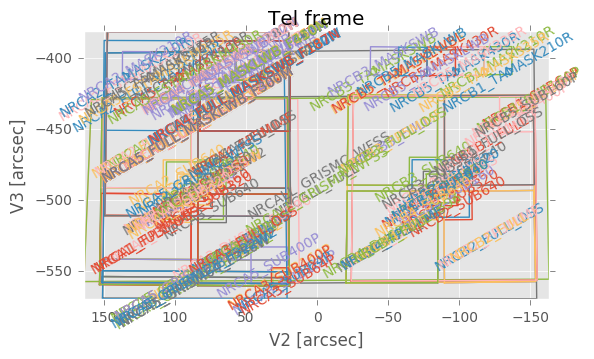

In [5]:
nircam_siaf.plot()

Woah, that's a bit hard to interpret! How many are we plotting?

In [6]:
len(nircam_siaf.apernames)

166

Some useful facts about the naming scheme:

  * Apertures with `OSS` in the name are used by the Onboard Scripting System, and are typically not of interest outside that context.
  * Apertures with `MASK` in the name are in the shifted field-of-view for the NIRCam coronagraphs and are only used for coronagraphy.

Omitting these apertures gives a more manageable plot. (When plotting an `Aperture` object, supply the `frame='Tel'` argument to `plot()` if you want to plot in the shared (V2, V3) coordinates.)

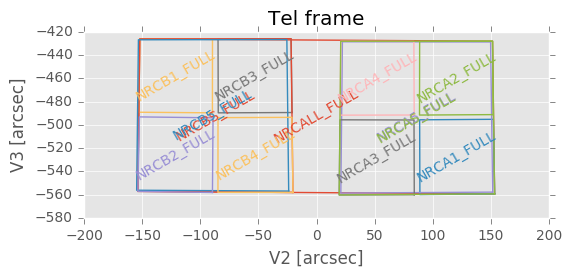

In [7]:
for apername in nircam_siaf.apernames:
    if '_FULL' in apername and 'OSS' not in apername and 'MASK' not in apername:
        nircam_siaf.apertures[apername].plot(frame='Tel')

## Coordinate conversions

So far we have been plotting in the *Tel* frame. Let's examine the direction of the V2 and V3 axes as seen in the *Det* frame to demonstrate the coordinate conversion methods. Detector axes on NIRSpec and MIRI are both rotated relative to (V2, V3) so let's pull out a MIRI aperture to use:

In [8]:
miri_siaf = SIAF('MIRI')
mirim_full = miri_siaf.apertures['MIRIM_FULL']

Plotting in the *Idl* frame, the edges of the MIRI imager full aperture are "straight" relative to the coordinate axes.

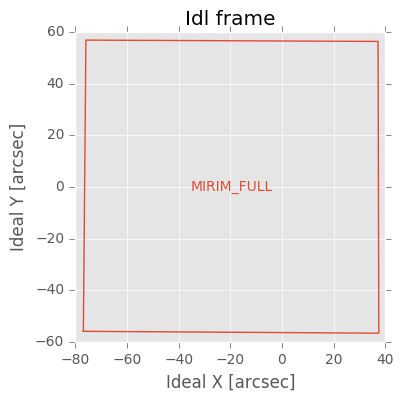

In [9]:
mirim_full.plot(frame='Idl')

We know the MIRI instrument is rotated relative to the (V2, V3) coordinates to fit it in the area of the focal plane with minimized wavefront error. To see this, we must plot in the *Tel* frame:

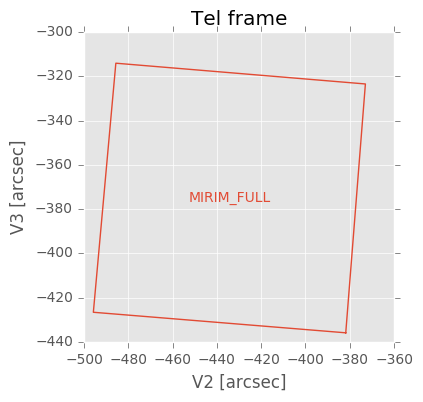

In [10]:
mirim_full.plot(frame='Tel')

Let's make some "test vectors" to see how the (V2, V3) axes get transformed into the *Idl* frame. First, plot vectors parallel to V2 and V3 in the *Tel* frame:

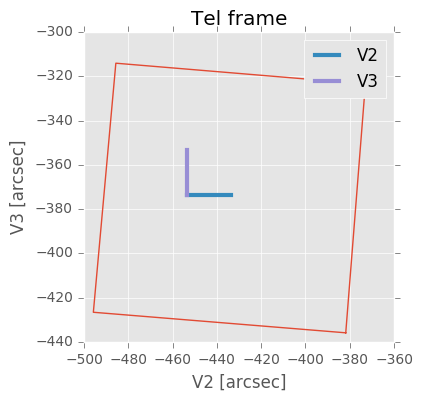

In [11]:
v2_ref, v3_ref = mirim_full.V2Ref, mirim_full.V3Ref
delta = 20 # arcsec

mirim_full.plot(frame='Tel', label=False)
plt.plot([v2_ref, v2_ref + delta], [v3_ref, v3_ref], label='V2', lw=3)
plt.plot([v2_ref, v2_ref], [v3_ref, v3_ref + delta], label='V3', lw=3)
plt.legend()

As expected, they are parallel with the plot axes (but not with the edges of the `MIRIM_FULL` aperture). Now, we convert from *Tel* to *Idl* with the aptly named `Tel2Idl` method of the `Aperture` instance named `mirim_full`.

In [12]:
v3_ref_idl_x, v3_ref_idl_y = mirim_full.Tel2Idl(v2_ref, v3_ref)
v2_vec_x, v2_vec_y = mirim_full.Tel2Idl(v2_ref + delta, v3_ref)
v3_vec_x, v3_vec_y = mirim_full.Tel2Idl(v2_ref, v3_ref + delta)

These converted coordinates are just regular Python floating point numbers, as you may expect. The (`V2Ref`, `V3Ref`) point corresponds to (0, 0) in *Idl* coordinates:

In [13]:
v3_ref_idl_x, v3_ref_idl_y

(-0.0, 0.0)

Let's plot the vectors in the *Idl* frame now and see how they compare:

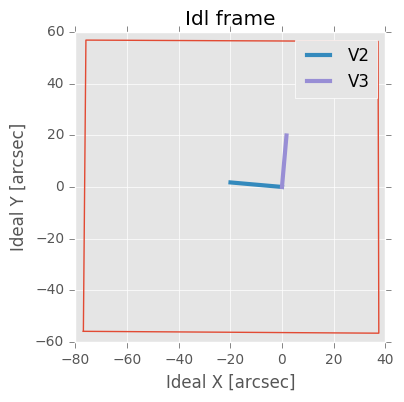

In [14]:
mirim_full.plot(frame='Idl', label=False)
plt.plot([0, v2_vec_x], [0, v2_vec_y], label='V2', lw=3)
plt.plot([0, v3_vec_x], [0, v3_vec_y], label='V3', lw=3)
plt.legend()

There's the rotation we expected, as well as a coordinate parity flip. Nice.

`jwxml` supports converting forward and backward between any pair of coordinate frames specified in the SIAF, through similarly named methods (e.g. `Tel2Idl`, `Idl2Sci`, `Tel2Det`, etc.). Be careful! Coordinates are tricky.

The SIAF provides a single, authoritative reference for coordinate transformations that account for the characteristics of the as-built instruments, tracked in the Project Reference Database. To understand the meaning of the various available `Aperture` attributes, you should consult JWST-STScI-001550 "Description and Use of the JWST Science Instrument Aperture File", by Cox et al. (2008).

This notebook was run with these software versions and reference file versions from the Project Reference Database (PRD):

In [15]:
print("jwxml version", jwxml.__version__)
print("PRD version", jwxml.PRD_VERSION)

jwxml version 0.2.0
PRD version PRDOPSSOC-E-002
